<a href="https://colab.research.google.com/github/theoem/Data-Linkage/blob/master/Data_imputation/Data_imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC3831 Data Imputation Coursework
Teodoras Celencevicius 190364247


Firstly, we will need to load the needed libraries

In [ ]:
import missingno as msno
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

pd.set_option('max_columns', None)

## Loading the data

### Loading the original data set

In [ ]:
original = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv')

### Loading the corrupted data

In [ ]:
files = [
         'houses_0.01_MAR.csv',
         'houses_0.01_MCAR.csv',
         'houses_0.01_MNAR.csv',
         'houses_0.1_MAR.csv',
         'houses_0.1_MCAR.csv',
         'houses_0.1_MNAR.csv',
         'houses_0.5_MAR.csv',
         'houses_0.5_MCAR.csv',
         'houses_0.5_MNAR.csv'
]
url = 'https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/CORRUPTED/HOUSES/'

In [ ]:
dfs = []

for file in files:
  dfs.append(pd.read_csv(url + file))
dfs

[       Unnamed: 0  median_house_value  median_income  housing_median_age  \
 0               0            452600.0         8.3252                41.0   
 1               1            358500.0         8.3014                21.0   
 2               2            352100.0         7.2574                52.0   
 3               3            341300.0         5.6431                52.0   
 4               4            342200.0         3.8462                52.0   
 ...           ...                 ...            ...                 ...   
 20635       20635             78100.0         1.5603                25.0   
 20636       20636             77100.0         2.5568                18.0   
 20637       20637             92300.0         1.7000                17.0   
 20638       20638             84700.0         1.8672                18.0   
 20639       20639             89400.0         2.3886                16.0   
 
        total_rooms  total_bedrooms  population  households  latitude  \
 

## Data exploration

Checking if each corrupted data set has the same shape and columns

In [ ]:
for df in dfs:
  print(df.shape)
  print(df.columns)

(20640, 10)
Index(['Unnamed: 0', 'median_house_value', 'median_income',
       'housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
       'households', 'latitude', 'longitude'],
      dtype='object')
(20640, 10)
Index(['Unnamed: 0', 'median_house_value', 'median_income',
       'housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
       'households', 'latitude', 'longitude'],
      dtype='object')
(20640, 10)
Index(['Unnamed: 0', 'median_house_value', 'median_income',
       'housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
       'households', 'latitude', 'longitude'],
      dtype='object')
(20640, 10)
Index(['Unnamed: 0', 'median_house_value', 'median_income',
       'housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
       'households', 'latitude', 'longitude'],
      dtype='object')
(20640, 10)
Index(['Unnamed: 0', 'median_house_value', 'median_income',
       'housing_median_age', 'total_rooms', 'total_bedrooms'

Since each corrupted data set has same shape and columns, each of them will look similar to this:

In [ ]:
dfs[0]

,Unnamed: 0,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
0,0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,2,352100.0,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,-122.24
3,3,341300.0,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,-122.25
4,4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25
...,...,...,...,...,...,...,...,...,...,...
20635,20635,78100.0,1.5603,25.0,1665.0,374.0,845.0,330.0,39.48,-121.09
20636,20636,77100.0,2.5568,18.0,697.0,150.0,356.0,114.0,39.49,-121.21
20637,20637,92300.0,1.7000,17.0,2254.0,485.0,1007.0,433.0,39.43,-121.22
20638,20638,84700.0,1.8672,18.0,1860.0,409.0,741.0,349.0,39.43,-121.32


Only keep the columns on which we apply regression

In [ ]:
index = 0
for df in dfs:
  dfs[index] = df.drop(['Unnamed: 0'], axis='columns')
  index+=0

Checking how many isnull values there are in each dataset

In [ ]:
index=0
for df in dfs:
  print(index)
  print(df.isnull().sum())
  index+=1

0
median_house_value        0
median_income         10320
housing_median_age    10320
total_rooms               0
total_bedrooms            0
population            10320
households                0
latitude                  0
longitude                 0
dtype: int64
1
Unnamed: 0              0
median_house_value      0
median_income         206
housing_median_age    206
total_rooms             0
total_bedrooms          0
population            206
households              0
latitude                0
longitude               0
dtype: int64
2
Unnamed: 0              0
median_house_value      0
median_income         206
housing_median_age    206
total_rooms             0
total_bedrooms          0
population            206
households              0
latitude                0
longitude               0
dtype: int64
3
Unnamed: 0               0
median_house_value       0
median_income         2064
housing_median_age    2064
total_rooms              0
total_bedrooms           0
population         

Only `median_income`, `housing_median_age` and `population` columns have missing values.

In [ ]:
original.columns

Index(['median_house_value', 'median_income', 'housing_median_age',
       'total_rooms', 'total_bedrooms', 'population', 'households', 'latitude',
       'longitude'],
      dtype='object')

Seperating the dataframe values into dependant variables and values to predict to prepare for the regression model

In [ ]:
x_columns = ['median_income', 'housing_median_age', 'total_rooms', 
                       'total_bedrooms', 'population', 'households', 
                       'latitude', 'longitude']
y_columns = 'median_house_value'

In [ ]:
x_original = original[x_columns].values
y_original = original[y_columns].values

Loading up the corrupted datasets and seperating the values int X and Y for the regression model

In [ ]:
x_houses = []
y_houses = []

index = 0
for df in dfs:
  x_houses.append(df[x_columns].values)
  y_houses.append(df[y_columns].values)

In [ ]:
print(len(x_houses))
print(len(y_houses))

9
9


## Experiment definition


During this experiment I will look into three imputation methods (KNN, univariate and multivariate) and compare their effectiveness when predicting `median_house_value`.

My hypotheses are:

1.   The performance of the imputation methods correlate to their complexity. That is, the performance will decrease the more complex method is. Therefore, my guess is that the performance will be decreasing in order of: Univariate Imputer, Multivariate imputer, KNN imputer.
2.   The effectiveness of the imputation methods will inversly correlate to the performance. Therefore, my guess is that the effectiveness will be increasing in order of: Univariate Imputer, Multivariate imputer, KNN imputer.
3.   The methods effectiveness will depend on the missingness in the data and the effectiveness will decrease in this order: MNAR, MAR, MCAR. 


I will measure the effectiveness of the methods by RMSE, because of the coursework guidelines.

## Defining the three imputation methods

### Nearest-neighbour imputation using sklearn KNNImputer class

In [ ]:
Xs_knni_fitted = []

def knni_imputer(data):
  imputer = KNNImputer(n_neighbors=2)
  return imputer.fit_transform(data)

Checking if it works

In [ ]:
print('Missing: %d' % sum(np.isnan(x_houses[0]).flatten()))
Xs_knni_fitted.append(knni_imputer(x_houses[0]))
print('Missing: %d' % sum(np.isnan(Xs_knni_fitted[0]).flatten()))


Missing: 30960
Missing: 0


applying for all of the corrupted data sets

In [ ]:
# Takes 3minutes to complete

Xs_knni_fitted = []

for X in x_houses:
  Xs_knni_fitted.append(knni_imputer(X))

### Univariate imputation using sklearn SimpleImputer class

In [ ]:
Xs_simple_fitted = []

def simple_imputer(data):
  imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
  return imputer.fit_transform(data)

Checking if it works

In [ ]:
print('Missing: %d' % sum(np.isnan(x_houses[0]).flatten()))
Xs_simple_fitted.append(simple_imputer(x_houses[0]))
print('Missing: %d' % sum(np.isnan(Xs_simple_fitted[0]).flatten()))


Missing: 30960
Missing: 0


applying for all of the corrupted data sets

In [ ]:
# Takes <1s to complete

Xs_simple_fitted = []

for X in x_houses:
  Xs_simple_fitted.append(simple_imputer(X))

### Multivariate Imputation using sklearn the IterativeImputer class


In [ ]:
Xs_iterative_fitted = []

def iterative_imputer(data):
  imputer = IterativeImputer(max_iter=10)
  return imputer.fit_transform(data)

Checking if it works

In [ ]:
print('Missing: %d' % sum(np.isnan(x_houses[0]).flatten()))
Xs_iterative_fitted.append(iterative_imputer(x_houses[0]))
print('Missing: %d' % sum(np.isnan(Xs_iterative_fitted[0]).flatten()))


Missing: 30960
Missing: 0


applying for all of the corrupted data sets

In [ ]:
# Takes 5s to complete

Xs_iterative_fitted = []

for X in x_houses:
  Xs_iterative_fitted.append(iterative_imputer(X))

## Performance results

The time imputation algorithm took to complete for all corrupted data sets:

*   KNN - 184.84s
*   Univariate - 0.006s
*   Multivariate - 4.002s




## Training our linear regression model using X with imputed values and y

In [ ]:
def linear_regression(X, Y):
  np.random.seed(42)  ## this makes the model reproducible

  kf = KFold(n_splits=4)  ## for k-fold validation

  ## generate K=4 models, one for each fold
  for train_index, test_index in kf.split(X):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = Y[train_index], Y[test_index]
      
      clf = LinearRegression()
      clf.fit(X_train, y_train)
      y_test_pred = clf.predict(X_test)

  return(mean_squared_error(y_test, y_test_pred, squared=False))

### Performing linear regression for the orginal, not corrupted data

In [ ]:
original_rmse = linear_regression(x_original, y_original)

### Performing linear regression for KNN imputed data



In [ ]:
index = 0
knn_rmses = []

for X in Xs_knni_fitted:
  knn_rmses.append(linear_regression(X, y_houses[index]))
  index+=1

In [ ]:
# Adding the original_rmse to the list for data vizualization

knn_rmses.append(original_rmse)

### Performing linear regression for univariate imputed data

In [ ]:
index = 0
uni_rmses = []

for X in Xs_simple_fitted:
  uni_rmses.append(linear_regression(X, y_houses[index]))
  index+=1

In [ ]:
# Adding the original_rmse to the list for data vizualization

uni_rmses.append(original_rmse)

### Performing linear regression for multivariate imputed data


In [ ]:
index = 0
multi_rmses = []

for X in Xs_iterative_fitted:
  multi_rmses.append(linear_regression(X, y_houses[index]))
  index+=1

In [ ]:
# Adding the original_rmse to the list for data vizualization

multi_rmses.append(original_rmse)

# Evaluation

For the evaluation of the results, I will be comparing RMSE of each linear regression model for corrupted datasets.

"As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable."

[source](https://www.theanalysisfactor.com/assessing-the-fit-of-regression-models/)

Therefore, **Lower values of RMSE indicate better fit.**

In [ ]:
missing_labels = [
         'houses_0.01_MAR',
         'houses_0.01_MCAR',
         'houses_0.01_MNAR',
         'houses_0.1_MAR',
         'houses_0.1_MCAR',
         'houses_0.1_MNAR',
         'houses_0.5_MAR',
         'houses_0.5_MCAR',
         'houses_0.5_MNAR',
         'original'
]

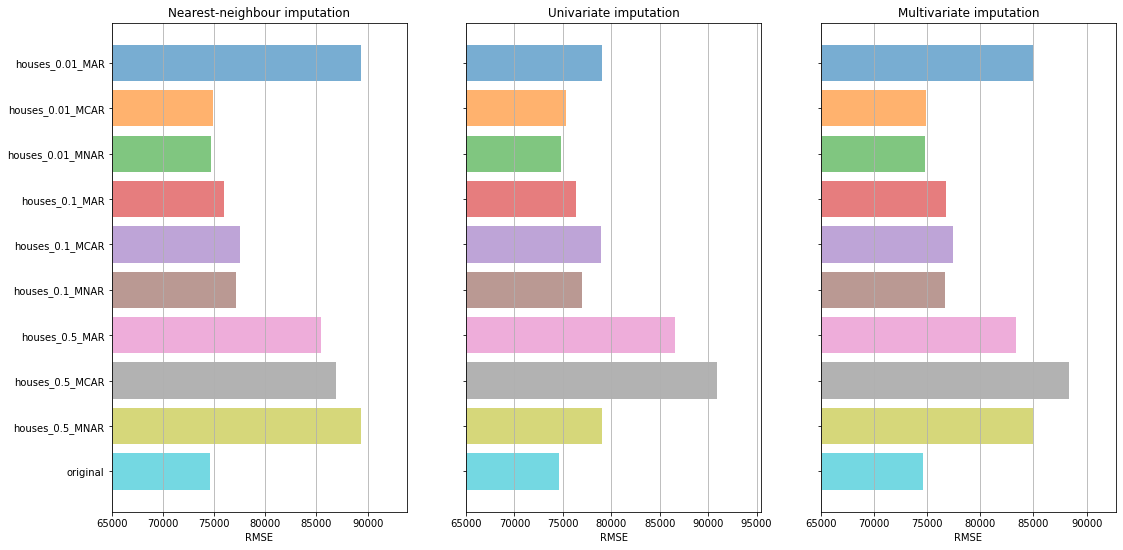

In [ ]:
import matplotlib.pyplot as plt


n_bars = len(missing_labels)
xval = np.arange(n_bars)
limit = 65000

fig, (ax1, ax2, ax3) = plt.subplots(sharey=True, 
                                    nrows=1, ncols=3, figsize=(18, 9))

# plot KNN imputation results
for j in xval:
    ax1.barh(j, knn_rmses[j], 
             alpha=0.6, align='center')

ax1.set_title('Nearest-neighbour imputation')
ax1.set_yticks(xval)
ax1.set_xlabel('RMSE')
ax1.invert_yaxis()
ax1.set_yticklabels(missing_labels)
ax1.set_xlim(left=limit)
ax1.grid(axis='x')

# plot univariate imputation results
for j in xval:
    ax2.barh(j, uni_rmses[j], 
             alpha=0.6, align='center')

ax2.set_title('Univariate imputation')
ax2.set_yticks(xval)
ax2.set_xlabel('RMSE')
ax2.invert_yaxis()
ax2.set_yticklabels(missing_labels)
ax2.set_xlim(left=limit)
ax2.grid(axis='x')

# plot multivariate imputation results
for j in xval:
    ax3.barh(j, multi_rmses[j], 
             alpha=0.6, align='center')

ax3.set_title('Multivariate imputation')
ax3.set_yticks(xval)
ax3.set_xlabel('RMSE')
ax3.invert_yaxis()
ax3.set_yticklabels(missing_labels)
ax3.set_xlim(left=limit)
ax3.grid(axis='x')

MAR - Missing At Random

MCAR - Missing Completely At Random

MNAR - Missing Not At Random


As expected, the original data set has the best RMSE score, which indicates that the regression model was somewhat correct.

### Evaluating the results against the hypotheses


#### First hypothesis

The first hypothesis verified as predicted. The performance of the methods decreased as the complexity increases.

The time imputation algorithm took to complete for all corrupted data sets:

1.   Univariate - 0.006s
2.   Multivariate - 4.002s
3.   KNN - 184.84s


What is interesting is the magnitude of difference of KNN performance compared to other methods. 

#### Second hypothesis

The second hypothesis is harder to evaluate as the effectiveness of different imputation methods differ on different missingness patters.

A way to evalue this numerically is add the RMSEs of each data sets and compare them.


In [ ]:
sum_rmse_knn = 0
sum_rmse_uni = 0
sum_rmse_multi = 0

# Removing the last values from the lists as they are RMSE of the original data
knn_rmses.pop()
uni_rmses.pop()
multi_rmses.pop()

print("KNN RMSE sum is:")
print(sum(knn_rmses))
print("Univariate RMSE sum is:")
print(sum(uni_rmses))
print("Multivariate RMSE sum is:")
print(sum(multi_rmses))

KNN RMSE sum is:
731450.0640186911
Univariate RMSE sum is:
717884.1583549335
Multivariate RMSE sum is:
722152.8150917874


Therefore, the effectiveness of each method are: 


1.   Univariate imputation
2.   Multivariate imputation
3.   KNN imputation



The results are the same as with performance. 

I found this unexpected, as more complex methods yield worse performance and worse effectiveness. However, it's important to note that insufficient method parameter tuning and regression model hyperparameter could have caused it.

#### Third hypothesis

Looking into the graph, a pattern can be seen that the same data missingness pattern yield the simmilar RMSE results over the different imputation methods. However, the hypothesis does not verify as there is no clear pattern in the graph that there is a correlation between the missingness pattern and effectiveness that is consistent between the different imputation methods. 

Interesting to note are a few unexpected results such as:

*   The increase of performance while using univariate imputation on the `houses_0.5_MNAR` dataset compared to other methods.
*   The decrease of performance while using KNN imputaton on the `houses_0.01_MAR` dataset compared to the other methods.



### Extension of the research


To extend this research it would be interesting to look into:

*   how the different parameters of the methods influence the performace and effectiveness. 
*   how different regression tehniques influence the results.
*   how the different hyperparameter of the regression algorithm influence the results.
*   finding patters on how effective the imputation methods are on individual missingness patterns and magnitude and why.

